# TA SESSION 3

## Complete Machine Learning Pipeline

In [115]:
EDA = False

## Imports

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from catboost import CatBoostRegressor

np.random.seed(98)

In [117]:
df = pd.read_parquet("../data/spotify/spotify.parquet")
df = df.drop(columns=["Unnamed: 0"])

target = "popularity"  # Try changing this to "danceability" and see what happens with the EDA!

<Axes: >

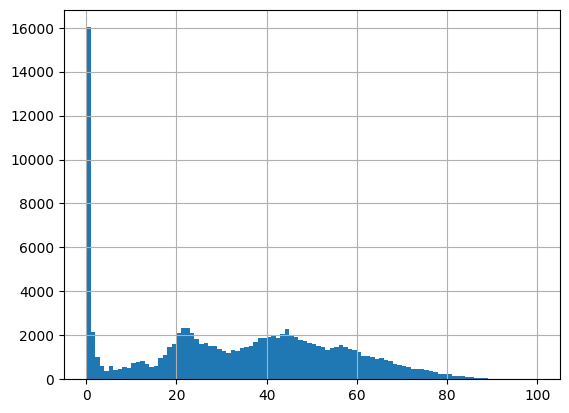

In [118]:
df[target].hist(bins=100)

In [119]:
display(df[target].describe())
median = df[target].median()
print(median)

count    114000.000000
mean         33.238535
std          22.305078
min           0.000000
25%          17.000000
50%          35.000000
75%          50.000000
max         100.000000
Name: popularity, dtype: float64

35.0


In [120]:
display(df[df[target] == median].shape[0])

1460

In [121]:
df_og = df.copy()

In [122]:
# In this case, we do not cut at the median anymore, we will later transform the target using a logit

## EDA for reference

In [123]:
display(df)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music
113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music
113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music
113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music


In [124]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
str_cols = df.select_dtypes(include="object").columns.tolist()

print("Numeric columns:", num_cols)
print("String columns:", str_cols)

print("\n")

df.info()

Numeric columns: ['popularity', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
String columns: ['track_id', 'artists', 'album_name', 'track_name', 'track_genre']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          1140

In [125]:
df.describe() # Only displays statistics for numeric columns

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


In [126]:
# Alternatively, we could print boxplots for all the numeric columns
if EDA:
    plt.figure(figsize=(15, 10))
    sns.boxplot(data=df[num_cols])
    plt.xticks(rotation=45)
    plt.show()

In [127]:
# Okey that wasn't too helpful, let's print boxplots for all the numeric columns again,
# but now we will use separate plots for each column and simply put them in a single figure
# with several rows of boxplots. We will print 5 rows with 3 boxplots each (we need to define this).

if EDA:
    nrows = 5
    ncols = 3

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 25)) # Create a grid of subplots
    # fig is the figures container, axes are the individual subplot axes, 2D numpy array
    # we access the axes like we would access the positions in a numpy 2D matrix.

    for i, feat in enumerate(num_cols): # We get idx and value for each element in num_cols (strings with names of titles)
        row = i // ncols # Integer division to get the row index
        col = i % ncols # Compute the residuals to get the column index. 0, 3, 6, 9 and 12 go in the first column (col=0)

        sns.boxplot(y=df[feat], ax=axes[row, col]) # We assign the variable to y so the boxplot is printed vertically
        axes[row, col].set_title(feat) # Set the title of each subplot

    axes[4, 2].axis("off") # We turn off the last axis for cleanliness, just so we don't print a blank plot 

    plt.tight_layout() # Overall cleanliness of the plot
    plt.show() # Show when done (Careful about plt.show() if you also want to save each plot at the same time)

In [128]:
# Now we analyze the correlation matrix of the numerical columns

if EDA:
    corr = df[num_cols].corr()
    display(corr.style.background_gradient(cmap='coolwarm', axis=None).format("{:.4f}"))

In [129]:
# def plot_scatter_target_with_other_var(df, target, var):
#     plt.figure(figsize=(10, 6))
#     sns.scatterplot(data=df, x=var, y=target)
#     plt.title(f"Scatter plot of {target} vs {var}")
#     plt.xlabel(var)
#     plt.ylabel(target)
#     plt.show()

# def plot_hist(df, var):
#     plt.figure(figsize=(10, 6))
#     sns.histplot(data=df, x=var, kde=True, color='darkblue')
#     plt.title(f"Distribution of {var}")
#     plt.xlabel(var)
#     plt.ylabel("Frequency")
#     plt.show()

In [130]:
# I'm going to select some variables which I think could be relevant and
# I'm going to plot them in a scatterplot against the target as well as 
# plotting their histogram with kernel density estimation right next to the scatterplot.

if EDA:
    sel_vars = ["energy", "danceability", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]

    fig, axes = plt.subplots(nrows=len(sel_vars), ncols=2, figsize=(15, 5 * len(sel_vars)))

    for i, var in enumerate(sel_vars):
        """
        Here I'm just going for basic scatterplots joined by histograms (with kernel density estimation because I like how smooth it looks).
        Each row contains the scatterplot and the histogram for the same variable together so they can be jointly analyzed.
        """
        sns.scatterplot(data=df_og, x=var, y=target, ax=axes[i, 0])
        axes[i, 0].set_title(f"Scatter plot of {target} vs {var}")
        axes[i, 0].set_xlabel(var)
        axes[i, 0].set_ylabel(target)

        sns.histplot(data=df_og, x=var, kde=True, color='darkblue', ax=axes[i, 1])
        axes[i, 1].set_title(f"Distribution of {var}")
        axes[i, 1].set_xlabel(var)
        axes[i, 1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

In [131]:
# Let's take a closer look at those weird observations in duration, tempo and time_signature
print(df.shape)

# DURATION
display(len(df[df["duration_ms"] == 0])) # We have only 1 observation with duration=0, let's print them and look at them
display(df[df["duration_ms"] == 0]) # It's clearly an error in the data, it is the only observation with missing metadata           
                                    # (artist, album, track name) so we should just drop it
df = df[df["duration_ms"] != 0].copy()


# TEMPO
display(len(df[df["tempo"] == 0])) # We have only 114 observations with tempo=0, let's print them and look at them
display(df[df["tempo"] == 0])   # Some of those songs are from Max Richter & Lang Lang, Lully or Louis Armstrong, and
                                # all of the songs with tempo=0 also have time_signature=0, so we can drop them.
df = df[df["tempo"] != 0].copy()


# TIME_SIGNATURE
display(len(df[df["time_signature"] == 0])) # Only 6 left with time_signature=0, let's take a look
display(len(df[df["time_signature"] == 1])) # Nearly 1000 observations with time_signature=1, let's take a look
display(df[df["time_signature"] == 0])
display(df[df["time_signature"] == 1]) # Many of those are in 4/4 time signature really, but we don't know, so we will drop them as well.
df = df[(df["time_signature"] != 0) & (df["time_signature"] != 1)].copy()

print(df.shape)

df.reset_index(drop=True, inplace=True)

(114000, 20)


1

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
65900,1kR4gIb7nGxHPI3D2ifs59,None,None,None,0,0,False,0.501,0.583,7,-9.46,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop


157

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
4131,59gg6zQhSKGVnkT3hWAY3l,Max Richter;Lang Lang,Voyager - Essential Max Richter,The Departure,64,151506,False,0.0,0.03620,0,-22.519,0,0.0,0.994000,0.940,0.0958,0.0,0.0,0,ambient
4379,4acmzQsAeMJa5sGFSog7fu,Dario Marianelli;Jack Liebeck;Benjamin Wallfisch,Jane Eyre - Original Motion Picture Soundtrack,The End of Childhood (feat. Jack Liebeck),55,73266,False,0.0,0.04450,0,-26.440,0,0.0,0.972000,0.972,0.0873,0.0,0.0,0,ambient
4664,1Kb2DqjHRvOcT5xeWtz3t5,Sylvain Chauveau,Des Plumes Dans La Tête,Ferme Les Yeux,53,68493,False,0.0,0.03230,2,-23.636,0,0.0,0.994000,0.973,0.0922,0.0,0.0,0,ambient
45670,6B9Mgf9smWqxDjA35VD6MK,Little Symphony,Rialto Beach,Campomoro,22,148711,False,0.0,0.00108,0,-30.204,1,0.0,0.952000,0.991,0.2420,0.0,0.0,0,guitar
45720,7i5OoyPXtSrqz9jobJfG1F,Little Symphony,Rialto Beach,Ritornello,23,102000,False,0.0,0.00129,7,-29.445,1,0.0,0.969000,0.956,0.1230,0.0,0.0,0,guitar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101988,5gEKRH0MCSegG8ZISUPaU2,Granular,The World Of,Tin White Noise,32,182050,False,0.0,0.00002,1,-16.187,1,0.0,0.003850,0.903,0.9210,0.0,0.0,0,sleep
101993,6H0kAiSAFB84jX7dgEDWd6,Rain Sounds,Rain,Rain: Natural Recording,32,84219,False,0.0,0.02540,8,-19.925,1,0.0,0.000002,0.838,0.3390,0.0,0.0,0,sleep
113428,5EYzrykQ95uOmepteDi9KT,El Ruido Blanco;Soñoliento Juan;Mantra para Do...,Aire Acondicionado de Ruido Blanco,Aire de verano,27,128000,False,0.0,0.18800,8,-25.837,0,0.0,0.139000,0.339,0.1220,0.0,0.0,0,world-music
113688,2EnZf7wbFv7ST4CJ3EvNzT,El Ruido Blanco,Ruido Blanco para el bebé: sonidos relajantes ...,Ruido Rosa Puro - Una Hora Versión,24,3601693,False,0.0,0.00002,1,-11.165,1,0.0,0.186000,1.000,0.3620,0.0,0.0,0,world-music


6

973

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
2926,0jdfbvSdaWvxfAlD20TtNc,Yaşlı Amca,Akşamüstü,Sanki Yapamadım,44,213198,False,0.442,0.56700,8,-6.346,0,0.0516,0.238,0.000325,0.0852,0.6390,138.616,0,alt-rock
26910,7HSc2wpHlXKIl8SCZK7zsP,Benny Martin,Here Comes the Sun (Piano Instrumental),Here Comes the Sun (Piano Instrumental),18,203705,False,0.329,0.06070,9,-28.310,1,0.0507,0.994,0.880000,0.0858,0.4210,93.948,0,disney
76259,5s4sjLD7BUMrRvwFLSDUUC,Josh Groban,Illuminations,Você Existe Em Mim,24,305786,False,0.225,0.71600,6,-6.131,1,0.0669,0.215,0.000029,0.0986,0.1360,153.274,0,opera
79999,4gHZlq1u5m89HP96BT3QHk,Dave Brubeck,A Dave Brubeck Christmas,"""Farewell"" Jingle Bells",29,179400,False,0.444,0.00402,2,-35.904,0,0.0750,0.996,0.908000,0.0599,0.0385,90.026,0,piano
98298,5Xc02eNu16HWnhEsyJKusZ,Heidi Blickenstaff;Susan Blackwell,[title of show] (Soundtrack From The Musical),Secondary Characters,28,145400,False,0.605,0.38300,0,-7.241,1,0.0643,0.801,0.000000,0.1540,0.3640,111.371,0,show-tunes
112172,0jdfbvSdaWvxfAlD20TtNc,Yaşlı Amca,Akşamüstü,Sanki Yapamadım,44,213198,False,0.442,0.56700,8,-6.346,0,0.0516,0.238,0.000325,0.0852,0.6390,138.616,0,turkish


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
117,65VhbQdqvozUntjnlFkFbZ,Kina Grannis,You Are My Sunshine,You Are My Sunshine,60,123609,False,0.664,0.0755,10,-19.836,1,0.0389,0.910,0.000000,0.1640,0.57500,80.004,1,acoustic
186,4bXoVtbp6fN8FaSQvGQB41,Chord Overstreet,Tree House Tapes,Tortured Soul,53,246613,False,0.550,0.4990,4,-9.502,1,0.0338,0.472,0.000002,0.0798,0.14400,86.966,1,acoustic
248,6OCsvPU6P84wJ0erggCRv4,Albert King,pov: you have a holly jolly christmas,Christmas Comes But Once A Year,0,272640,False,0.687,0.4940,1,-9.421,1,0.0505,0.324,0.000055,0.0867,0.62100,93.269,1,acoustic
249,7qJtNgmUyzy3R86vJwk9Wp,Albert King,pov: you rock around the christmas tree,Christmas Comes But Once A Year,0,272640,False,0.687,0.4940,1,-9.421,1,0.0505,0.324,0.000055,0.0867,0.62100,93.269,1,acoustic
286,2Dz5WpEWA0vhnMmEPYiZ2y,Parachute,Losing Sleep,She Is Love,60,146066,False,0.629,0.1740,6,-9.697,1,0.1410,0.616,0.000000,0.1180,0.30500,134.295,1,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113593,6H1U6y9b0htZoSCfROkKgh,Ruido Blanco Hart,Juegos para el Cerebro - La Mejor Música Relaj...,Mejora la Memoria,25,403999,False,0.208,0.1510,4,-17.049,1,0.0493,0.994,0.967000,0.0933,0.07090,115.146,1,world-music
113686,0VI2Pe8VIcAQoGg42Zs2vA,Reiki Armonía,Sonidos de Fondo para Reiki: Gotas de Agua,"Para Reiki: Gotas de Agua, Pt. 24",25,109506,False,0.139,0.9250,10,-32.267,0,0.0474,0.131,0.992000,0.8950,0.00271,85.949,1,world-music
113791,03KJvToiQ5xkTvgii0iVuJ,Lucas Cervetti,Frecuencias Álmicas en 432hz,"Frecuencia Álmica, Pt. 1",23,421000,False,0.196,0.1260,2,-15.217,1,0.0306,0.976,0.905000,0.0639,0.07960,99.783,1,world-music
113819,0MGaMJckimN7NUtJNofC02,Agua Mantra,"Salida del Sol: Poder del Cerebro, Musica para...",Eternidad,22,370999,False,0.165,0.1460,0,-23.202,1,0.0426,0.972,0.264000,0.2290,0.05520,93.777,1,world-music


(112863, 20)


In [132]:
df["track_genre"].value_counts()

track_genre
rock             1000
salsa            1000
dance            1000
house            1000
chicago-house    1000
                 ... 
grindcore         964
classical         958
ambient           958
comedy            944
sleep             805
Name: count, Length: 114, dtype: int64

In [133]:
df["key"].value_counts().sort_index()

key
0     12943
1     10614
2     11531
3      3517
4      8943
5      9250
6      7839
7     13131
8      7283
9     11232
10     7367
11     9213
Name: count, dtype: int64

In [134]:
df.rename(columns={"mode": "major"}, inplace=True)
df["major"].value_counts()

major
1    71921
0    40942
Name: count, dtype: int64

## Pipeline Code

### Index

1. [Preprocessing + Feature Engineering](#preprocessing-+-feature-engineering)

2. [Model Definition](#model-definition)

3. [Data Split, Fit and Predict](#data-split,-fit-and-predict)

4. [Model Evaluation](#model-evaluation)

### Preprocessing + Feature Engineering

In [135]:
df.describe()

,popularity,duration_ms,danceability,energy,key,loudness,major,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,112863.000000,1.128630e+05,112863.000000,112863.000000,112863.000000,112863.000000,112863.000000,112863.000000,112863.000000,112863.000000,112863.000000,112863.000000,112863.000000,112863.000000
mean,33.269335,2.282811e+05,0.568837,0.643684,5.312326,-8.199521,0.637242,0.084413,0.312265,0.154050,0.212945,0.475943,122.437781,3.934708
std,22.333646,1.059998e+05,0.171772,0.249659,3.560344,4.945812,0.480798,0.104344,0.330916,0.307632,0.189572,0.258595,29.633223,0.305593
min,0.000000,1.580000e+04,0.051300,0.000020,0.000000,-46.591000,0.000000,0.022100,0.000000,0.000000,0.009250,0.000000,30.200000,3.000000
25%,17.000000,1.745450e+05,0.458000,0.475000,2.000000,-9.955000,0.000000,0.035900,0.016700,0.000000,0.097900,0.262000,99.747500,4.000000
50%,35.000000,2.131200e+05,0.582000,0.686000,5.000000,-6.975000,1.000000,0.049000,0.166000,0.000040,0.132000,0.466000,122.057000,4.000000
75%,50.000000,2.616375e+05,0.695000,0.854000,8.000000,-4.991000,1.000000,0.084600,0.591000,0.045750,0.273000,0.684000,140.105000,4.000000
max,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


#### Handling Categorical Variables

We will be preparing the handling of the categorical variables and also preparing the different sets for the pre-processing step of the pipeline.

In [136]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include="object").columns.tolist()
print(df.columns)

"""
We establish several sets of features: numerical, categorical, binary and probabilistic
    - Numerical: Features that take continuous values
    - Categorical: Features that represent categories or groups. From those, we will drop 'time_signature' for simplicity.
        - OneHot: We will one-hot encode 'key'
        - TargetEncode: We will target encode 'track_genre'
    - Binary: Features that have two possible values (e.g., 0/1), passed through the pre-processing steps
    - Probabilistic: Features that represent probabilities or likelihoods (e.g. danceability, speechiness), passed through the pre-processing steps
"""

num_cols = ["duration_ms", "tempo", "loudness"]
cat_cols = ["track_genre", "key", "time_signature"]
bin_cols = ["explicit", "major"]
prob_cols = ["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"]

# Really the important lists from categorical are these two:
oh_cols = ["key"]
te_cols = ["track_genre"]

Index(['track_id', 'artists', 'album_name', 'track_name', 'popularity',
       'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
       'major', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'track_genre'],
      dtype='object')


In [137]:
"""
At a first glance, there are some features which really need some handling: key, time_signature and track_genre (bonus track, explicit).
    - key: This is a categorical variable but it's currently being treated as a numerical variable. I'm really not a fan of the way it's encoded so I'll start by reverting it.
            We will be turning it back into a categorical variable and then you choose whether to one-hot encode it or not.
    - time_signature: This variable is also categorical and should be treated as such. But more important than that, 0/4 and 1/4 are REALLY weird values.
                        We will be turning it into two separate binary variables: 3_4 and 4_4 (5_4 is REALLY weird to dance to so it might be worth having it as the baseline).
    - track_genre: This is another categorical variable that needs to be encoded.
                    You will be choosing whether to drop it or use target encoding on it.
    - explicit: Simply turn it from a True/False binary into a 0/1 binary, no big deal.
"""

# We start with "explicit" because the solution is super simple.
df["explicit"] = df["explicit"].astype(int)

# Now we map the numerical key values to their corresponding musical note names, for clarity if we choose to one-hot encode it later.
key_map = {
    0: "C",
    1: "C#/Db",
    2: "D",
    3: "D#/Eb",
    4: "E",
    5: "F",
    6: "F#/Gb",
    7: "G",
    8: "G#/Ab",
    9: "A",
    10: "A#/Bb",
    11: "B"
}

df["key"] = df["key"].map(key_map)

df

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,major,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,0,0.676,0.4610,C#/Db,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,0,0.420,0.1660,C#/Db,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,0,0.438,0.3590,C,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,0,0.266,0.0596,C,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,0,0.618,0.4430,D,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112858,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,0,0.172,0.2350,F,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music
112859,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,0,0.174,0.1170,C,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music
112860,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,0,0.629,0.3290,C,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music
112861,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,0,0.587,0.5060,G,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music


In [138]:
"""
The features which are still defined in categories are: (unique)track_id, artists, album_name, track_name and track_genre.

Out of those, we can only realistically use track_genre. Any other of those variables is more of an identification variable.
Any predictive power that could come from those variables would probably have it because of being from a specific genre or from another one.
An artist who usually produces edm might have most of their tracks as highly danceable, but if they suddenly release an album of piano ballads, that could change
for that album specifically. Granted, this change in danceability would be captured by the album variable, but it would also be captured by the track_genre variable anyway.

To sum up, we are only keeping track_genre for reasons of avoiding having unmanageable dimensionality and to prevent the model to rely too much on features it can't be trained on
when making predictions for unseen data (newly released tracks).
"""

df = df.drop(columns=["track_id", "artists", "album_name", "track_name"])
df

,popularity,duration_ms,explicit,danceability,energy,key,loudness,major,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,73,230666,0,0.676,0.4610,C#/Db,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,55,149610,0,0.420,0.1660,C#/Db,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,57,210826,0,0.438,0.3590,C,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,71,201933,0,0.266,0.0596,C,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,82,198853,0,0.618,0.4430,D,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112858,21,384999,0,0.172,0.2350,F,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music
112859,22,385000,0,0.174,0.1170,C,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music
112860,22,271466,0,0.629,0.3290,C,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music
112861,41,283893,0,0.587,0.5060,G,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music


#### Preprocessing Step using Column Transformer

- One hot encoder: It's not necessary to integrate it in the pipeline, but it's cleaner if we do since we are already using sklearn pipelines.

- Target Encoder: In this case it IS essential to integrate target encoder in the pipeline to avoid data leakage. If we encode using the target outside of the pipeline we would need a very careful cross-validation scheme to avoid data leakage. By integrating it in the pipeline we ensure that the encoding is done only on the training folds during cross-validation, thus avoiding data leakage.

In [139]:
onehot_enc = OneHotEncoder(sparse_output=False, drop="first")
target_encoder = TargetEncoder(target_type="continuous", random_state=98)

# bin_scaler = StandardScaler()
# pca = PCA(n_components=0.95)

bin_preproc = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))
])

preproc = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("oh", onehot_enc, oh_cols),
            ("te", target_encoder, te_cols), # Notice that we encode using the original y (not the logit transformed t), it should be a bit better (higher variance before transforming, thus more information when target encoding)
            ("bin", "passthrough", bin_cols),
            ("prob", "passthrough", prob_cols)
            # ("bin", bin_preproc, bin_cols),
            # ("prob", pca, prob_cols)    
        ],
        remainder="drop"  # This drops any columns not specified in the transformers
)

# preproc2 = ColumnTransformer(
#         transformers=[
#             ("num", "passthrough", num_cols),
#             ("oh", "passthrough", oh_cols),
#             ("te", "passthrough", te_cols),
#             ("bin", pca, bin_cols+prob_cols)
#         ],
#         remainder="drop"  # This drops any columns not specified in the transformers
# )

### Model Definition

We define all the algorithms that we plan to potentially try out in the pipeline.

Its important to set `n_jobs=1` in all models that support parallelization when using them inside sklearn pipelines or gridsearches to avoid conflicts with parallelization at higher levels (i.e. cross-validation).

In [140]:
# Gradient boosters / trees
xgb  = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    n_jobs=1,
    random_state=98
)

cat  = CatBoostRegressor(
    loss_function="RMSE",
    random_state=98,
    verbose=False
)

rf   = RandomForestRegressor(
    n_estimators=50,
    max_depth=None,
    min_samples_leaf=5,
    max_features="sqrt",
    n_jobs=1,
    random_state=98
)

# Linear & kernelized
ridge = Ridge(random_state=98)
lasso = Lasso(max_iter=10000, random_state=98)

#### Hyperparameter Grids

Here we set up all the grids for the different algorithms that we plan to try out.

In [141]:
grids = {
    "xgb": {
        "model__regressor__max_depth": [4, 6, 8],
        "model__regressor__learning_rate": [0.03, 0.05, 0.1],
        "model__regressor__reg_lambda": [1.0, 3.0],
        "model__regressor__subsample": [0.7, 0.9],
        "model__regressor__colsample_bytree": [0.7, 0.9],
    },
    "cat": { #CatBooster has a pretty good internal optimization algorithm which provides super good results "out of the box"
        "model__regressor__iterations": [1000],
    },
    "rf": {
        "model__regressor__max_depth": [None],
        "model__regressor__min_samples_leaf": [1],
        "model__regressor__max_features": ["sqrt"],
    },
    "ridge": {
        "model__regressor__alpha": [0.1, 1.0, 10.0],
    },
    "lasso": {
        "model__regressor__alpha": [0.1, 1.0, 10.0],
    },
}

#### Transformed Target Regressor?

We will use TrasformedTargetRegressor to handle the logit transformation of the target variable within the pipeline.

This is only needed to make our life easier and is not strictly necessary to avoid data leakage. We could also do the transformation manually before fitting the model and then inverse transform the predictions afterwards. However, using TransformedTargetRegressor makes the code cleaner and easier to read and, since we are already using sklearn pipelines, it's nice and easy to integrate it this way.

#### Make Pipeline function

It's just a function that we will use to create a pipeline with the chosen estimator below. We switch algorithms by hand in this case, we are not including algorithm selection in the gridsearch to keep things simpler.

In [142]:
def make_pipeline(estimator, target_function, inverse_target_function):
    ttr = TransformedTargetRegressor(
        regressor=estimator,
        func=target_function,
        inverse_func=inverse_target_function
    )
    
    return Pipeline([
        ("preproc", preproc),
        # ("postproc", preproc2),
        ("model", ttr)
    ])

In order to appropriately handle the target variable in this case, we need to apply a logit transformation to it.
We transform it as follows:

```math
t = logit\left(\frac{y + \epsilon}{100 + 2\epsilon}\right) , \text{with } \epsilon = 10^{-3}
```

where:

```math
logit(p) = ln\left(\frac{p}{1-p}\right)
```

We can try different values for epsilon, we can tune it as a hyperparameter after finding an optimal set in the main gridsearch. We could implement it in the search, but we would need to tweak a few things and I want to keep the code simpler than this for now. It's also fine to simply tune epsilon manually by running the pipeline multiple times with different values. The main values we could try are:

```math
\epsilon \in \{ 0.5, 10^{-1}, 10^{-3}, 10^{-5}\}
```

For now we start with `epsilon = 1e-3` as it should be a good compromise.

In [143]:
EPS = 1e-3

def y_to_t(y, eps=EPS):
    y = np.asarray(y, dtype=float)          # Ensure y is a numpy array of floats
    p = (y + eps) / (100.0 + 2.0*eps)       # Compute the normalized value inside the parentheses
    p = np.clip(p, 1e-12, 1 - 1e-12)        # Clip p to avoid log(0) issues
    return np.log(p / (1.0 - p))            # Apply the logit transformation

def t_to_y(t, eps=EPS):                     # Inverse of the logit transformation
    p = 1.0 / (1.0 + np.exp(-t))            # Apply the logistic function to get back p
    return (100.0 + 2.0*eps) * p - eps      # Denormalize and get back to y

In [144]:
"""
Let's also try to have the option of simply predicting the target as it is [0-100],
and having the inverse simply clip the predicted values to be within [0, 100].
"""

def y_neutral(y):
    return y

def y_pred_clip(y):
    return np.clip(y, 0, 100)

In [145]:
"""
Choose youre model here:
    - xgb: XGBoost Regressor
    - rf: Random Forest Regressor
    - cat: CatBoost Regressor
    - ridge: Ridge Regression
    - lasso: Lasso Regression
"""
# est_name, est = "xgb", xgb
# est_name, est = "rf", rf
# est_name, est = "cat", cat
# est_name, est = "ridge", ridge
est_name, est = "lasso", lasso

In [146]:
# pipe = make_pipeline(est, y_to_t, t_to_y)
pipe = make_pipeline(est, y_neutral, y_pred_clip)

param_grid = grids[est_name]

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=2
)

pipe

,steps,"[('preproc', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('oh', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Data Split, Fit and Predict

In [147]:
X = df.drop(columns=[target])
y = df[target].copy()

display(X)
display(y)

,duration_ms,explicit,danceability,energy,key,loudness,major,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,230666,0,0.676,0.4610,C#/Db,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,149610,0,0.420,0.1660,C#/Db,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,210826,0,0.438,0.3590,C,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,201933,0,0.266,0.0596,C,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,198853,0,0.618,0.4430,D,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112858,384999,0,0.172,0.2350,F,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music
112859,385000,0,0.174,0.1170,C,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music
112860,271466,0,0.629,0.3290,C,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music
112861,283893,0,0.587,0.5060,G,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music


0         73
1         55
2         57
3         71
4         82
          ..
112858    21
112859    22
112860    22
112861    41
112862    22
Name: popularity, Length: 112863, dtype: int64

In [148]:
# We split the data here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=98)

display(y_test.head())

23081    45
57962    23
10701     4
15128    61
71159    40
Name: popularity, dtype: int64

In [149]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ........................model__regressor__alpha=0.1; total time=   0.4s
[CV] END ........................model__regressor__alpha=0.1; total time=   0.4s
[CV] END ........................model__regressor__alpha=0.1; total time=   0.4s
[CV] END ........................model__regressor__alpha=0.1; total time=   0.4s
[CV] END ........................model__regressor__alpha=0.1; total time=   0.4s
[CV] END ........................model__regressor__alpha=1.0; total time=   0.2s
[CV] END ........................model__regressor__alpha=1.0; total time=   0.4s
[CV] END ........................model__regressor__alpha=1.0; total time=   0.3s
[CV] END ........................model__regressor__alpha=1.0; total time=   0.1s
[CV] END ........................model__regressor__alpha=1.0; total time=   0.1s
[CV] END .......................model__regressor__alpha=10.0; total time=   0.1s
[CV] END .......................model__regressor_

,estimator,Pipeline(step..._state=98)))])
,param_grid,"{'model__regressor__alpha': [0.1, 1.0, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('oh', ...), ...]"


## Model Evaluation

In [150]:
best_model = grid.best_estimator_
print("Best hyperparameters:", grid.best_params_)
print("Best CV score (RMSE):", np.sqrt(np.abs(grid.best_score_)))

"""
NO NEED TO FIT AGAIN ONTO THE WHOLE TRAINING SET,
GridSearch CV already does it during grid.fit() whenever refit=True (we are not changing it and the default is True).
"""
y_pred = grid.predict(X_test)
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MAE:", mean_absolute_error(y_test, y_pred))

Best hyperparameters: {'model__regressor__alpha': 0.1}
Best CV score (RMSE): 19.29840939962942
Test RMSE: 19.282527097863984
Test MAE: 14.19598744786436


In order to create the final predictions to submit them to us, I recommend that you use the best estimator (best hyperparameters) found during your cross-validation grid search and fit them to not only your training set but to your whole dataset. Remember that when you do train_test_split on your data, you are really splitting your original training set into a smaller training set and a hold-out set, but for your submitted predictions you should use all the data you have available to train your final model.

In [151]:
"""
You can first flip the thread usage so you use all the threads for your single fit
"""

# lasso, ridge xgboost and catboost don't have an n_jobs parameter so you should comment the next line out before running with those models.
# best_model.named_steps['model'].regressor.set_params(n_jobs=-1)
best_model.fit(X, y)

"""
Obviously in this case I don't have a separate df_test without target variables, but you get the idea.
I'm just creating a small random sample from the original df here, but you would use your actual dataset loaded from:
df_test_oos = pd.read_csv("path_to_MIMIC_test.csv")
"""
df_test_oos = df.sample(n=10, random_state=98).drop(columns=[target])
y_pred = best_model.predict(df_test_oos)

Given that our target variable takes values between 0 and 100, we can create a baseline for comparison, to evaluate how good our model is.

To do this, we will compute the RMSE of a naive model that always predicts the mean of the target variable in the training set.

In [152]:
def mean_prediction(X_test, y_train):
    """
    This function computes the mean of the target variable y and returns it as predictions for all observations in X_test.
    """
    y_bar = np.mean(y_train)
    return np.ones(X_test.shape[0]) * y_bar

y_pred_mean = mean_prediction(X_test, y_train)
print("Mean prediction RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_mean)))

Mean prediction RMSE: 22.365869368641917
